# Importación de liberias

In [1]:
import numpy as np
import pandas as pd
import sympy as sp

# Creacion del dataset

In [3]:
# Configuraciones iniciales
np.random.seed(42)  # Para reproducibilidad
g = 9.81  # Gravedad en m/s^2
num_samples = 5000  # Número de trayectorias

# Generación de valores aleatorios para las variables
velocidades_iniciales = np.random.uniform(10, 100, num_samples)  # m/s
angulos = np.random.uniform(10, 80, num_samples)  # grados
masas = np.random.uniform(0.5, 10, num_samples)  # kg
constantes_resistencia = np.random.uniform(0.1, 1.0, num_samples)  # kg/m

In [4]:
# Método numérico para simular trayectorias (Euler)
def simular_trayectoria(v0, theta, m, c, dt=0.01, max_time=10):
    theta_rad = np.radians(theta)  # Convertir ángulo a radianes
    vx = v0 * np.cos(theta_rad)  # Componente horizontal de la velocidad
    vy = v0 * np.sin(theta_rad)  # Componente vertical de la velocidad

    # Posiciones iniciales
    x, y = 0, 0
    trayectoria = []

    for _ in np.arange(0, max_time, dt):
        ax = -(c / m) * vx  # Aceleración en x
        ay = -g - (c / m) * vy  # Aceleración en y

        # Actualizar velocidades
        vx += ax * dt
        vy += ay * dt

        # Actualizar posiciones
        x += vx * dt
        y += vy * dt

        # Guardar la posición
        trayectoria.append((x, y))

        # Detener si toca el suelo
        if y < 0:
            break

    return trayectoria

## Generación del dataset

In [5]:
# Generación del dataset
data = []
for v0, theta, m, c in zip(
    velocidades_iniciales, angulos, masas, constantes_resistencia
):
    trayectoria = simular_trayectoria(v0, theta, m, c)
    for punto in trayectoria:
        data.append([v0, theta, m, c, punto[0], punto[1]])  # Guardar datos

# Convertir a DataFrame
columnas = [
    "velocidad_inicial",
    "angulo",
    "masa",
    "constante_resistencia",
    "pos_x",
    "pos_y",
]
datos = pd.DataFrame(data, columns=columnas)

# Guardar el dataset en un archivo CSV
datos.to_csv("trayectorias_proyectil.csv", index=False)

print("Generación de datos completada. Guardado en 'trayectorias_proyectil.csv'.")


Generación de datos completada. Guardado en 'trayectorias_proyectil.csv'.


## Red neuronal

#### Entrenamiento de la red 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

/home/topo/Documents/Universidad/2024-2/InteligentesII/intelligent-II-neuronal-networks/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18222/18222 ━━━━━━━━━━━━━━━━━━━━ 8s 453us/step - loss: 2888.9905 - mae: 34.6961
Pérdida (Loss): 2889.3845, Error Absoluto Medio (MAE): 34.7014
18222/18222 ━━━━━━━━━━━━━━━━━━━━ 8s 412us/step
MAE para pos_x: 47.9718, MAE para pos_y: 21.4310
MSE para pos_x: 4747.1875, MSE para pos_y: 1024.2725
R² para pos_x: 0.5468, R² para pos_y: 0.7482
Precisión dentro del rango de tolerancia (1.0 unidades): 0.30%


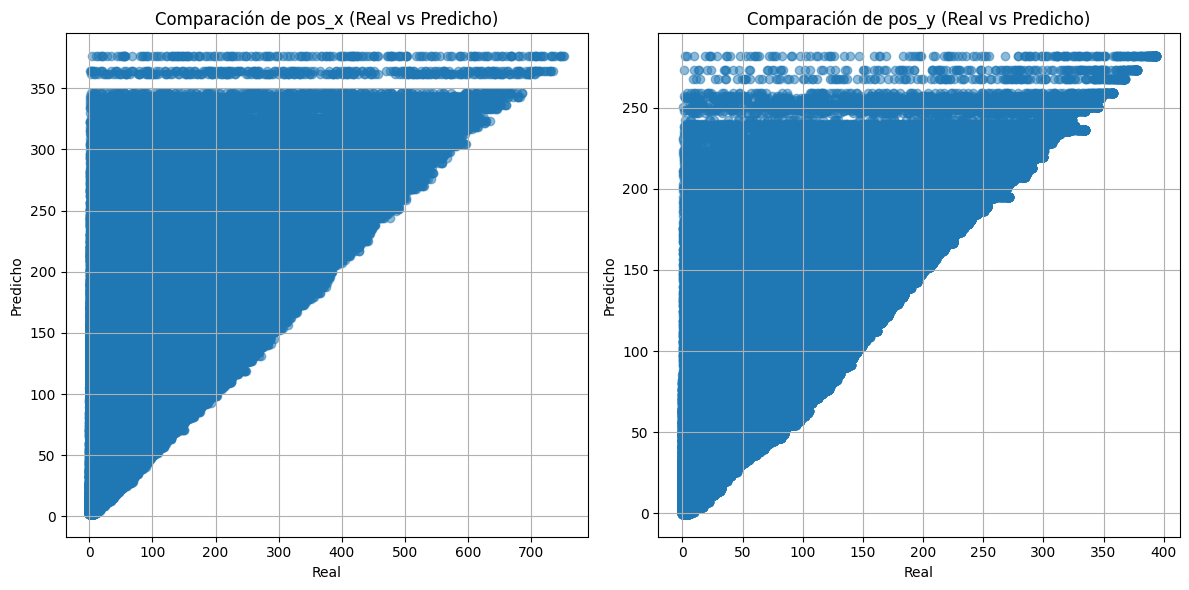

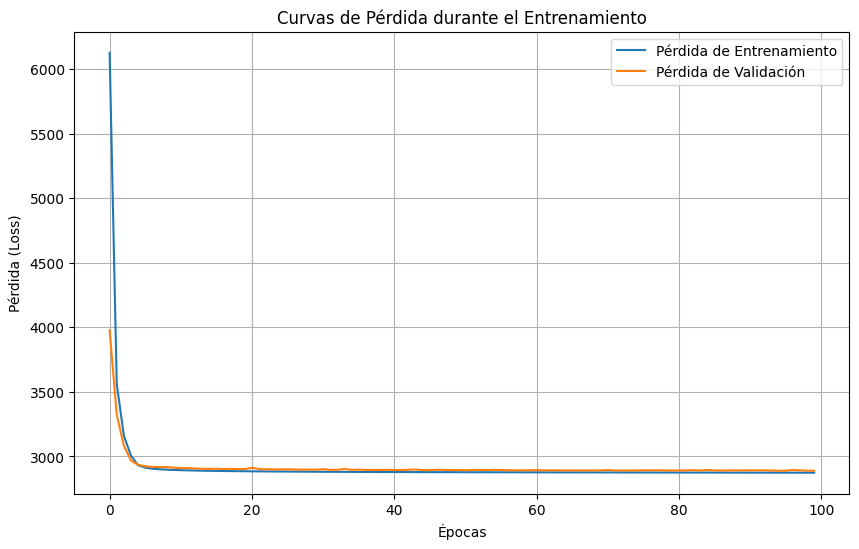

In [ ]:
# Cargar el dataset generado
datos = pd.read_csv("trayectorias_proyectil.csv")

# Separar características (X) y etiquetas (y)
X = datos[["velocidad_inicial", "angulo", "masa", "constante_resistencia"]].values
y = datos[["pos_x", "pos_y"]].values

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ** Anterior
# Escalar los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ** anterior estaba 64 - 64
# Crear el modelo de red neuronal profunda
model = Sequential(
    [
        Dense(32, input_dim=4, activation="relu"),
        Dense(16, activation="relu", kernel_regularizer="l2"),
        Dense(2, activation="linear"),
    ]
)

# ** Anterior
# Compilar el modelo
# model.compile(
#    optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"]
# )

model.compile(
    optimizer=RMSprop(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"]
)

# model.add(Dropout(0.3))

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_test, y_test),
    verbose=0,
)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test)
print(f"Pérdida (Loss): {loss:.4f}, Error Absoluto Medio (MAE): {mae:.4f}")

# Predicciones en el conjunto de prueba
predicciones = model.predict(X_test)

# Calcular métricas de regresión
mae_x = mean_absolute_error(y_test[:, 0], predicciones[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], predicciones[:, 1])

mse_x = mean_squared_error(y_test[:, 0], predicciones[:, 0])
mse_y = mean_squared_error(y_test[:, 1], predicciones[:, 1])

r2_x = r2_score(y_test[:, 0], predicciones[:, 0])
r2_y = r2_score(y_test[:, 1], predicciones[:, 1])

print(f"MAE para pos_x: {mae_x:.4f}, MAE para pos_y: {mae_y:.4f}")
print(f"MSE para pos_x: {mse_x:.4f}, MSE para pos_y: {mse_y:.4f}")
print(f"R² para pos_x: {r2_x:.4f}, R² para pos_y: {r2_y:.4f}")


# Precisión personalizada: porcentaje de predicciones dentro de una tolerancia
def accuracy_within_tolerance(y_true, y_pred, tolerance=0.1):
    diff = np.abs(y_true - y_pred)
    within_tolerance = np.all(diff <= tolerance, axis=1)
    return np.mean(within_tolerance) * 100


accuracy = accuracy_within_tolerance(y_test, predicciones, tolerance=1.0)
print(f"Precisión dentro del rango de tolerancia (1.0 unidades): {accuracy:.2f}%")

# Visualizar las predicciones vs valores reales (pos_x y pos_y separadamente)
plt.figure(figsize=(12, 6))

# Comparar pos_x
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], predicciones[:, 0], alpha=0.5)
plt.title("Comparación de pos_x (Real vs Predicho)")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)

# Comparar pos_y
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], predicciones[:, 1], alpha=0.5)
plt.title("Comparación de pos_y (Real vs Predicho)")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)

plt.tight_layout()
plt.show()

# Curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.title("Curvas de Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid(True)
plt.show()